In [17]:
import sys

sys.path.insert(0, '/home/caron/Bureau/Model/HexagonalScale/ST-GNN-for-wildifre-prediction/Prediction')

from config import *
from tools import *
from features import *

path_to_dfs = Path('firemen/firepoint/2x2/train/occurence_default/')

name = 'df_train_full_0_all_4_0_risk-size-watershed_node.pkl'
name1 = 'df_train_full_0_all_5_0_risk-size-watershed_node.pkl'
name2 = 'df_train_full_0_all_6_0_risk-size-watershed_node.pkl'
name3 = 'df_train_full_0_all_7_0_risk-size-watershed_node.pkl'
name4 = 'df_train_full_0_all_departement_0_None_node.pkl'

df_test = read_object(name, path_to_dfs)
df_test['Scale'] = 4

df_test1 = read_object(name1, path_to_dfs)
df_test1['Scale'] = 5

df_test2 = read_object(name2, path_to_dfs)
df_test2['Scale'] = 6

df_test3 = read_object(name3, path_to_dfs)
df_test3['Scale'] = 7

df_test4 = read_object(name4, path_to_dfs)
df_test4['Scale'] = 'Department'


df_test = pd.concat((df_test, df_test1, df_test2, df_test3, df_test4)).reset_index(drop=True)

In [18]:
df_test.Scale.unique()

array([4, 5, 6, 7, 'Department'], dtype=object)

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_bar_chart_by_scale(data, column_name_1, column_name_2, scale_column):
    """
    Plot the percentage distribution of two columns as grouped bar charts for each unique scale.

    Parameters:
        data (DataFrame): The pandas DataFrame containing the data.
        column_name_1 (str): The first column to visualize.
        column_name_2 (str): The second column to visualize.
        scale_column (str): The name of the scale column.
    """
    # Calculate percentage distribution for each scale and column
    percentages_1 = data.groupby(scale_column)[column_name_1].value_counts(normalize=True).mul(100).rename('Percentage_1').reset_index()
    percentages_2 = data.groupby(scale_column)[column_name_2].value_counts(normalize=True).mul(100).rename('Percentage_2').reset_index()

    # Get unique scales
    unique_scales = data[scale_column].unique()

    # Set up a 3x2 grid for plotting
    num_scales = len(unique_scales)
    plots_per_page = 6  # 3 columns x 2 rows
    num_pages = math.ceil(num_scales / plots_per_page)

    for page in range(num_pages):
        # Create a new figure
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()  # Flatten to make it easier to iterate over

        # Get the scales for this page
        start_idx = page * plots_per_page
        end_idx = min(start_idx + plots_per_page, num_scales)
        scales_on_page = unique_scales[start_idx:end_idx]

        for i, scale in enumerate(scales_on_page):
            ax = axes[i]
            # Filter data for the current scale
            scale_data_1 = percentages_1[percentages_1[scale_column] == scale]
            scale_data_2 = percentages_2[percentages_2[scale_column] == scale]

            # Get categories (x-ticks)
            categories = list(set(scale_data_1[column_name_1]) | set(scale_data_2[column_name_2]))

            # Align data to all categories (to handle missing values)
            scale_data_1 = scale_data_1.set_index(column_name_1).reindex(categories).fillna(0).reset_index()
            scale_data_2 = scale_data_2.set_index(column_name_2).reindex(categories).fillna(0).reset_index()

            # Bar positions
            bar_width = 0.4
            x = range(len(categories))

            # Plot bar chart for column_name_1
            ax.bar(
                [pos - bar_width / 2 for pos in x],
                scale_data_1['Percentage_1'],
                width=bar_width,
                label=column_name_1,
                color='skyblue',
                edgecolor='black'
            )

            # Plot bar chart for column_name_2
            ax.bar(
                [pos + bar_width / 2 for pos in x],
                scale_data_2['Percentage_2'],
                width=bar_width,
                label=column_name_2,
                color='salmon',
                edgecolor='black'
            )

            # Set chart title and labels
            ax.set_title(f"Scale: {scale}", fontsize=12)
            ax.set_xlabel("Categories", fontsize=10)
            ax.set_ylabel("Percentage (%)", fontsize=10)
            ax.set_xticks(x)
            ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=8)
            ax.set_ylim(0, 100)  # Set y-axis to 0-100 for percentage scale

            # Add percentages as text above the bars
            for bar, percent in zip(ax.patches, list(scale_data_1['Percentage_1']) + list(scale_data_2['Percentage_2'])):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 1,
                    f"{percent:.1f}%",
                    ha='center',
                    fontsize=8
                )

            # Add legend
            ax.legend(fontsize=8, loc='upper right')

        # Hide unused subplots
        for j in range(len(scales_on_page), len(axes)):
            fig.delaxes(axes[j])

        # Adjust layout
        plt.tight_layout()
        plt.show()


In [20]:
df_test.rename({'nbsinister-kmeans-5-Class-Dept' : 'Raw Class', 'nbsinister-kmeans-5-Class-Dept-laplace+mean-Specialized' : 'laplace+mean Class'}, inplace=True, axis=1)

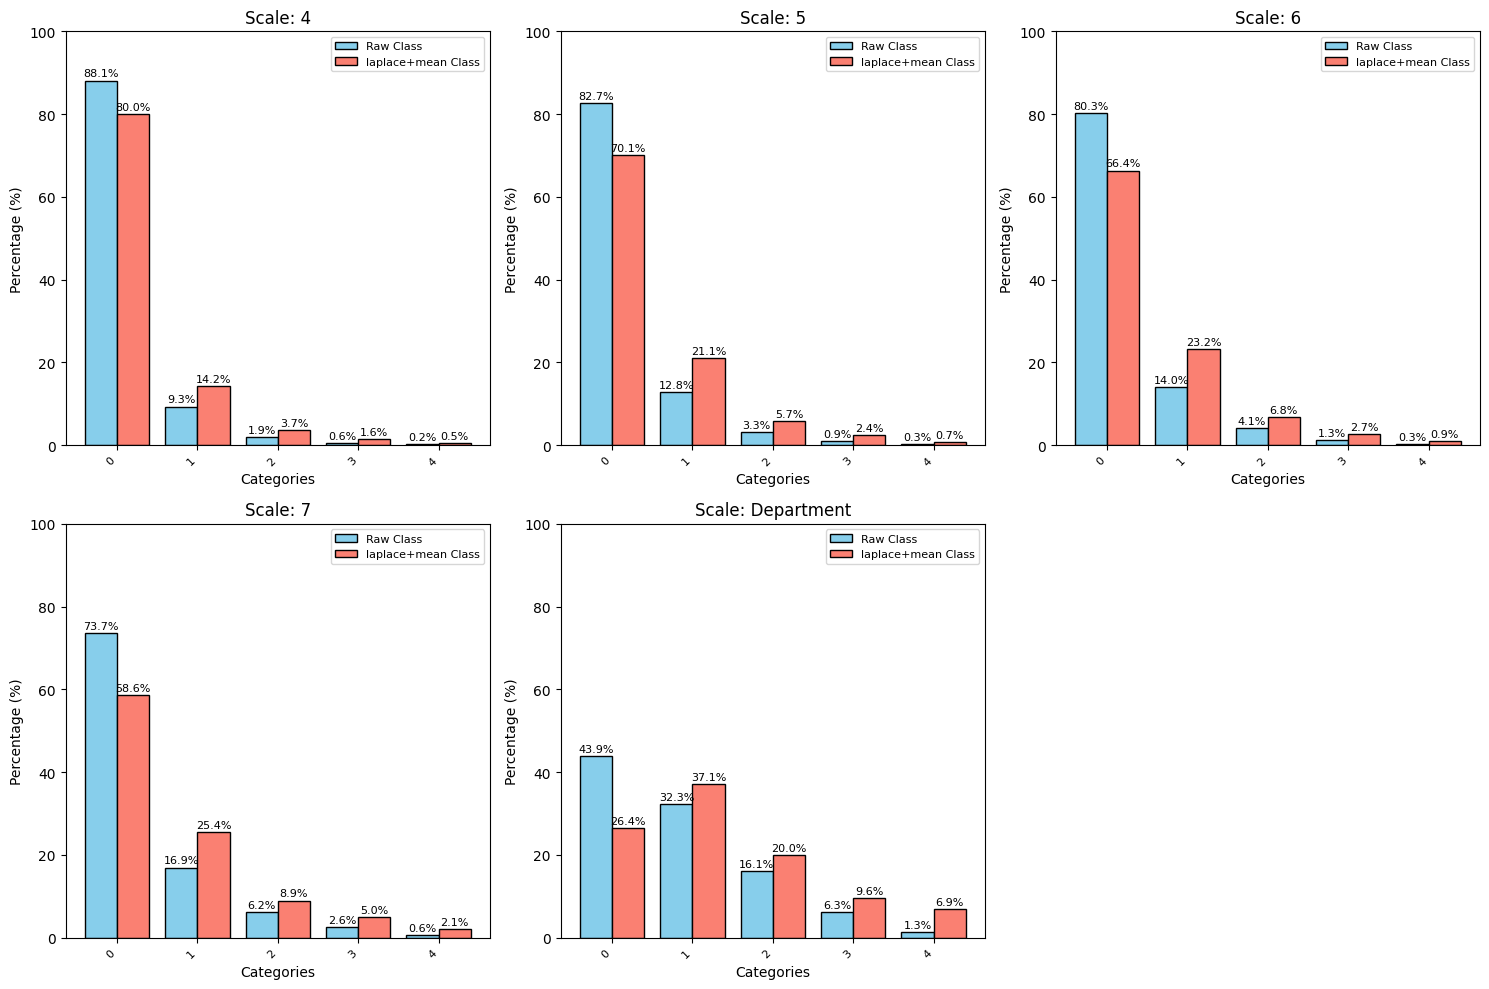

In [21]:
plot_bar_chart_by_scale(df_test, column_name_1='Raw Class', column_name_2='laplace+mean Class', scale_column='Scale')

### Plotting

In [22]:
from GNN.graph_structure import *

def remove_bad_pixel(data, mask):
    nan_mask = np.isnan(data)  # Masque des NaN
    filled_raster = data.copy()  # Copie du tableau original

    nearest_indices = ndimage.distance_transform_edt(
        nan_mask,
        return_distances=False,
        return_indices=True
    )

    # Utiliser les indices pour remplir les NaN avec les valeurs les plus proches
    filled_raster = data.copy()
    filled_raster[nan_mask] = data[tuple(nearest_indices[:, nan_mask])]

    # Remettre à jour raster_node
    data = filled_raster
    data[np.isnan(mask)] = np.nan

    return data

In [23]:
from GNN.arborescence import *

target_ain = read_object('departement-01-ainInfluence.pkl', root_target / 'firepoint' / 'firemen' / 'occurence' / 'log' / '2x2')
target_doubs = read_object('departement-25-doubsInfluence.pkl', root_target / 'firepoint' / 'firemen' / 'occurence' / 'log' / '2x2')
target_yvelines = read_object('departement-78-yvelinesInfluence.pkl', root_target / 'firepoint' / 'firemen' / 'occurence' / 'log' / '2x2')
target_rhone = read_object('departement-69-rhoneInfluence.pkl', root_target / 'firepoint' / 'firemen' / 'occurence' / 'log' / '2x2')
target_her = read_object('departement-34-heraultInfluence.pkl', root_target / 'firepoint' / 'bdiff' / 'occurence' / 'log' / '2x2')
target_br = read_object('departement-13-bouches-du-rhoneInfluence.pkl', root_target / 'firepoint' / 'bdiff' / 'occurence' / 'log' / '2x2')

target_ain = np.nansum(target_ain, axis=2)
target_doubs = np.nansum(target_doubs, axis=2)
target_yvelines = np.nansum(target_yvelines, axis=2)
target_rhone = np.nansum(target_rhone, axis=2)
target_her = np.nansum(target_her, axis=2)
target_br = np.nansum(target_br, axis=2)

population_ain = read_object('population.pkl', rootDisk / 'csv' / 'departement-01-ain' / 'raster' / '2x2')
population_doubs = read_object('population.pkl', rootDisk / 'csv' / 'departement-25-doubs' / 'raster' / '2x2')
population_yvelines = read_object('population.pkl', rootDisk / 'csv' / 'departement-78-yvelines' / 'raster' / '2x2')
population_rhone = read_object('population.pkl', rootDisk / 'csv' / 'departement-69-rhone' / 'raster' / '2x2')
population_her = read_object('population.pkl', rootDisk / 'csv' / 'departement-34-herault' / 'raster' / '2x2')
population_br = read_object('population.pkl', rootDisk / 'csv' / 'departement-13-bouches-du-rhone' / 'raster' / '2x2')

target_ain[np.isnan(population_ain)] = np.nan
target_doubs[np.isnan(population_doubs)] = np.nan
target_yvelines[np.isnan(population_yvelines)] = np.nan
target_rhone[np.isnan(population_rhone)] = np.nan
target_her[np.isnan(population_her)] = np.nan
target_br[np.isnan(population_br)] = np.nan

dir_scale = Path('firemen2/firepoint/2x2/train/raster')

scale4_ain = read_object('pred_departement-01-ain_4_no_background_watershed.pkl', dir_scale)
scale4_doubs = read_object('pred_departement-25-doubs_4_no_background_watershed.pkl', dir_scale)
scale4_yvelines = read_object('pred_departement-78-yvelines_4_no_background_watershed.pkl', dir_scale)
scale4_rhone = read_object('pred_departement-69-rhone_4_no_background_watershed.pkl', dir_scale)

scale7_ain = read_object('pred_departement-01-ain_7_no_background_watershed.pkl', dir_scale)
scale7_doubs = read_object('pred_departement-25-doubs_7_no_background_watershed.pkl', dir_scale)
scale7_yvelines = read_object('pred_departement-78-yvelines_7_no_background_watershed.pkl', dir_scale)
scale7_rhone = read_object('pred_departement-69-rhone_7_no_background_watershed.pkl', dir_scale)

scale5_ain = read_object('pred_departement-01-ain_5_no_background_watershed.pkl', dir_scale)
scale5_doubs = read_object('pred_departement-25-doubs_5_no_background_watershed.pkl', dir_scale)
scale5_yvelines = read_object('pred_departement-78-yvelines_5_no_background_watershed.pkl', dir_scale)
scale5_rhone = read_object('pred_departement-69-rhone_5_no_background_watershed.pkl', dir_scale)

scale6_ain = read_object('pred_departement-01-ain_6_no_background_watershed.pkl', dir_scale)
scale6_doubs = read_object('pred_departement-25-doubs_6_no_background_watershed.pkl', dir_scale)
scale6_yvelines = read_object('pred_departement-78-yvelines_6_no_background_watershed.pkl', dir_scale)
scale6_rhone = read_object('pred_departement-69-rhone_6_no_background_watershed.pkl', dir_scale)

dir_scale = Path('bdiff/firepoint/2x2/train/raster')

scale4_her = read_object('pred_departement-34-herault_4_no_background_watershed.pkl', dir_scale)
scale4_br = read_object('pred_departement-13-bouches-du-rhone_4_no_background_watershed.pkl', dir_scale)

scale5_her = read_object('pred_departement-34-herault_5_no_background_watershed.pkl', dir_scale)
scale5_br = read_object('pred_departement-13-bouches-du-rhone_5_no_background_watershed.pkl', dir_scale)

scale6_her = read_object('pred_departement-34-herault_6_no_background_watershed.pkl', dir_scale)
scale6_br = read_object('pred_departement-13-bouches-du-rhone_6_no_background_watershed.pkl', dir_scale)

scale7_her = read_object('pred_departement-34-herault_7_no_background_watershed.pkl', dir_scale)
scale7_br = read_object('pred_departement-13-bouches-du-rhone_7_no_background_watershed.pkl', dir_scale)

# Apply remove_bad_pixel to all scales for each department using the corresponding population data

# For department Ain
scale4_ain = remove_bad_pixel(scale4_ain, population_ain)
scale5_ain = remove_bad_pixel(scale5_ain, population_ain)
scale6_ain = remove_bad_pixel(scale6_ain, population_ain)
scale7_ain = remove_bad_pixel(scale7_ain, population_ain)

# For department Doubs
scale4_doubs = remove_bad_pixel(scale4_doubs, population_doubs)
scale5_doubs = remove_bad_pixel(scale5_doubs, population_doubs)
scale6_doubs = remove_bad_pixel(scale6_doubs, population_doubs)
scale7_doubs = remove_bad_pixel(scale7_doubs, population_doubs)

# For department Yvelines
scale4_yvelines = remove_bad_pixel(scale4_yvelines, population_yvelines)
scale5_yvelines = remove_bad_pixel(scale5_yvelines, population_yvelines)
scale6_yvelines = remove_bad_pixel(scale6_yvelines, population_yvelines)
scale7_yvelines = remove_bad_pixel(scale7_yvelines, population_yvelines)

# For department Rhone
scale4_rhone = remove_bad_pixel(scale4_rhone, population_rhone)
scale5_rhone = remove_bad_pixel(scale5_rhone, population_rhone)
scale6_rhone = remove_bad_pixel(scale6_rhone, population_rhone)
scale7_rhone = remove_bad_pixel(scale7_rhone, population_rhone)

# For dclustering_epartment Herault
scale4_her = remove_bad_pixel(scale4_her, population_her)
scale5_her = remove_bad_pixel(scale5_her, population_her)
scale6_her = remove_bad_pixel(scale6_her, population_her)
scale7_her = remove_bad_pixel(scale7_her, population_her)

# For dclustering_epartment Br
scale4_br = remove_bad_pixel(scale4_br, population_br)
scale5_br = remove_bad_pixel(scale5_br, population_br)
scale6_br = remove_bad_pixel(scale6_br, population_br)
scale7_br = remove_bad_pixel(scale7_br, population_br)

dir_scale = Path('firemen2/firepoint/2x2/train/raster')

scale4_clustering_ain = read_object('pred_departement-01-ain_4_no_background_clustering.pkl', dir_scale)
scale4_clustering_doubs = read_object('pred_departement-25-doubs_4_no_background_clustering.pkl', dir_scale)
scale4_clustering_yvelines = read_object('pred_departement-78-yvelines_4_no_background_clustering.pkl', dir_scale)
scale4_clustering_rhone = read_object('pred_departement-69-rhone_4_no_background_clustering.pkl', dir_scale)

scale7_clustering_ain = read_object('pred_departement-01-ain_7_no_background_clustering.pkl', dir_scale)
scale7_clustering_doubs = read_object('pred_departement-25-doubs_7_no_background_clustering.pkl', dir_scale)
scale7_clustering_yvelines = read_object('pred_departement-78-yvelines_7_no_background_clustering.pkl', dir_scale)
scale7_clustering_rhone = read_object('pred_departement-69-rhone_7_no_background_clustering.pkl', dir_scale)

scale5_clustering_ain = read_object('pred_departement-01-ain_5_no_background_clustering.pkl', dir_scale)
scale5_clustering_doubs = read_object('pred_departement-25-doubs_5_no_background_clustering.pkl', dir_scale)
scale5_clustering_yvelines = read_object('pred_departement-78-yvelines_5_no_background_clustering.pkl', dir_scale)
scale5_clustering_rhone = read_object('pred_departement-69-rhone_5_no_background_clustering.pkl', dir_scale)

scale6_clustering_ain = read_object('pred_departement-01-ain_6_no_background_clustering.pkl', dir_scale)
scale6_clustering_doubs = read_object('pred_departement-25-doubs_6_no_background_clustering.pkl', dir_scale)
scale6_clustering_yvelines = read_object('pred_departement-78-yvelines_6_no_background_clustering.pkl', dir_scale)
scale6_clustering_rhone = read_object('pred_departement-69-rhone_6_no_background_clustering.pkl', dir_scale)

dir_scale = Path('bdiff/firepoint/2x2/train/raster')

scale4_clustering_her = read_object('pred_departement-34-herault_4_no_background_clustering.pkl', dir_scale)
scale4_clustering_br = read_object('pred_departement-13-bouches-du-rhone_4_no_background_clustering.pkl', dir_scale)

scale5_clustering_her = read_object('pred_departement-34-herault_5_no_background_clustering.pkl', dir_scale)
scale5_clustering_br = read_object('pred_departement-13-bouches-du-rhone_5_no_background_clustering.pkl', dir_scale)

scale6_clustering_her = read_object('pred_departement-34-herault_6_no_background_clustering.pkl', dir_scale)
scale6_clustering_br = read_object('pred_departement-13-bouches-du-rhone_6_no_background_clustering.pkl', dir_scale)

scale7_clustering_her = read_object('pred_departement-34-herault_7_no_background_clustering.pkl', dir_scale)
scale7_clustering_br = read_object('pred_departement-13-bouches-du-rhone_7_no_background_clustering.pkl', dir_scale)

# For department Ain
scale4_clustering_ain = remove_bad_pixel(scale4_clustering_ain, population_ain)
scale5_clustering_ain = remove_bad_pixel(scale5_clustering_ain, population_ain)
scale6_clustering_ain = remove_bad_pixel(scale6_clustering_ain, population_ain)
scale7_clustering_ain = remove_bad_pixel(scale7_clustering_ain, population_ain)

# For dclustering_epartment Doubs
scale4_clustering_doubs = remove_bad_pixel(scale4_clustering_doubs, population_doubs)
scale5_clustering_doubs = remove_bad_pixel(scale5_clustering_doubs, population_doubs)
scale6_clustering_doubs = remove_bad_pixel(scale6_clustering_doubs, population_doubs)
scale7_clustering_doubs = remove_bad_pixel(scale7_clustering_doubs, population_doubs)

# For dclustering_epartment Yvelines
scale4_clustering_yvelines = remove_bad_pixel(scale4_clustering_yvelines, population_yvelines)
scale5_clustering_yvelines = remove_bad_pixel(scale5_clustering_yvelines, population_yvelines)
scale6_clustering_yvelines = remove_bad_pixel(scale6_clustering_yvelines, population_yvelines)
scale7_clustering_yvelines = remove_bad_pixel(scale7_clustering_yvelines, population_yvelines)

# For dclustering_epartment Rhone
scale4_clustering_rhone = remove_bad_pixel(scale4_clustering_rhone, population_rhone)
scale5_clustering_rhone = remove_bad_pixel(scale5_clustering_rhone, population_rhone)
scale6_clustering_rhone = remove_bad_pixel(scale6_clustering_rhone, population_rhone)
scale7_clustering_rhone = remove_bad_pixel(scale7_clustering_rhone, population_rhone)

# For dclustering_epartment Herault
scale4_clustering_her = remove_bad_pixel(scale4_clustering_her, population_her)
scale5_clustering_her = remove_bad_pixel(scale5_clustering_her, population_her)
scale6_clustering_her = remove_bad_pixel(scale6_clustering_her, population_her)
scale7_clustering_her = remove_bad_pixel(scale7_clustering_her, population_her)

# For dclustering_epartment Br
scale4_clustering_br = remove_bad_pixel(scale4_clustering_br, population_br)
scale5_clustering_br = remove_bad_pixel(scale5_clustering_br, population_br)
scale6_clustering_br = remove_bad_pixel(scale6_clustering_br, population_br)
scale7_clustering_br = remove_bad_pixel(scale7_clustering_br, population_br)

import numpy as np

def sum_target_by_scale(target, scale, scale_id_column='id'):
    """
    Sum the target values for each unique scale ID.
    
    Parameters:
    - target: Array of target values (e.g., the fire distribution).
    - scale: Array representing the scale corresponding to each target value (e.g., scale4 or scale7).
    - scale_id_column: Name of the scale ID column (default is 'id').
    
    Returns:
    - summed_scale: Array where each pixel corresponds to the sum of target values for each unique scale ID.
    """
    # Ensure scale and target have the same shape
    if target.shape != scale.shape:
        raise ValueError("The target and scale arrays must have the same shape.")
    
    # Create an empty array to hold the summed values
    summed_scale = np.zeros_like(scale, dtype=float)
    
    # Iterate through each unique scale ID
    unique_ids = np.unique(scale[~np.isnan(scale)])
    
    for scale_id in unique_ids:
        # Find the pixels that correspond to the current scale ID
        mask = (scale == scale_id)
        
        # Sum the target values for the current scale ID
        summed_scale[mask] = np.sum(target[mask])
    
    summed_scale[np.isnan(scale)] = np.nan
    return summed_scale

# Apply to each scale
"""scale4_ain = sum_target_by_scale(target=target_ain, scale=scale4_ain)
scale4_doubs = sum_target_by_scale(target=target_doubs, scale=scale4_doubs)
scale4_yvelines = sum_target_by_scale(target=target_yvelines, scale=scale4_yvelines)
scale4_rhone = sum_target_by_scale(target=target_rhone, scale=scale4_rhone)

scale7_ain = sum_target_by_scale(target=target_ain, scale=scale7_ain)
scale7_doubs = sum_target_by_scale(target=target_doubs, scale=scale7_doubs)
scale7_yvelines = sum_target_by_scale(target=target_yvelines, scale=scale7_yvelines)
scale7_rhone = sum_target_by_scale(target=target_rhone, scale=scale7_rhone)

scale4_clustering_ain = sum_target_by_scale(target=target_ain, scale=scale4_clustering_ain)
scale4_clustering_doubs = sum_target_by_scale(target=target_doubs, scale=scale4_clustering_doubs)
scale4_clustering_yvelines = sum_target_by_scale(target=target_yvelines, scale=scale4_clustering_yvelines)
scale4_clustering_rhone = sum_target_by_scale(target=target_rhone, scale=scale4_clustering_rhone)

scale7_clustering_ain = sum_target_by_scale(target=target_ain, scale=scale7_clustering_ain)
scale7_clustering_doubs = sum_target_by_scale(target=target_doubs, scale=scale7_clustering_doubs)
scale7_clustering_yvelines = sum_target_by_scale(target=target_yvelines, scale=scale7_clustering_yvelines)
scale7_clustering_rhone = sum_target_by_scale(target=target_rhone, scale=scale7_clustering_rhone)"""

# Optionally, replace the original variables with the new summed scales
# This will make the scale arrays hold the summed target values


'scale4_ain = sum_target_by_scale(target=target_ain, scale=scale4_ain)\nscale4_doubs = sum_target_by_scale(target=target_doubs, scale=scale4_doubs)\nscale4_yvelines = sum_target_by_scale(target=target_yvelines, scale=scale4_yvelines)\nscale4_rhone = sum_target_by_scale(target=target_rhone, scale=scale4_rhone)\n\nscale7_ain = sum_target_by_scale(target=target_ain, scale=scale7_ain)\nscale7_doubs = sum_target_by_scale(target=target_doubs, scale=scale7_doubs)\nscale7_yvelines = sum_target_by_scale(target=target_yvelines, scale=scale7_yvelines)\nscale7_rhone = sum_target_by_scale(target=target_rhone, scale=scale7_rhone)\n\nscale4_clustering_ain = sum_target_by_scale(target=target_ain, scale=scale4_clustering_ain)\nscale4_clustering_doubs = sum_target_by_scale(target=target_doubs, scale=scale4_clustering_doubs)\nscale4_clustering_yvelines = sum_target_by_scale(target=target_yvelines, scale=scale4_clustering_yvelines)\nscale4_clustering_rhone = sum_target_by_scale(target=target_rhone, scale=

In [24]:
data = {
    "ain": {
        "target": target_ain,
        "population": population_ain,
        "scale4": scale4_ain,
        "scale5": scale5_ain,
        "scale6": scale6_ain,
        "scale7": scale7_ain,
        "scale4_clustering": scale4_clustering_ain,
        "scale5_clustering": scale5_clustering_ain,
        "scale6_clustering": scale6_clustering_ain,
        "scale7_clustering": scale7_clustering_ain,
    },
    "doubs": {
        "target": target_doubs,
        "population": population_doubs,
        "scale4": scale4_doubs,
        "scale5": scale5_doubs,
        "scale6": scale6_doubs,
        "scale7": scale7_doubs,
        "scale4_clustering": scale4_clustering_doubs,
        "scale5_clustering": scale5_clustering_doubs,
        "scale6_clustering": scale6_clustering_doubs,
        "scale7_clustering": scale7_clustering_doubs,
    },
    "yvelines": {
        "target": target_yvelines,
        "population": population_yvelines,
        "scale4": scale4_yvelines,
        "scale5": scale5_yvelines,
        "scale6": scale6_yvelines,
        "scale7": scale7_yvelines,
        "scale4_clustering": scale4_clustering_yvelines,
        "scale5_clustering": scale5_clustering_yvelines,
        "scale6_clustering": scale6_clustering_yvelines,
        "scale7_clustering": scale7_clustering_yvelines,
    },
    "rhone": {
        "target": target_rhone,
        "population": population_rhone,
        "scale4": scale4_rhone,
        "scale5": scale5_rhone,
        "scale6": scale6_rhone,
        "scale7": scale7_rhone,
        "scale4_clustering": scale4_clustering_rhone,
        "scale5_clustering": scale5_clustering_rhone,
        "scale6_clustering": scale6_clustering_rhone,
        "scale7_clustering": scale7_clustering_rhone,
    },

    "herault": {
        "target": target_her,
        "population": population_her,
        "scale4": scale4_her,
        "scale5": scale5_her,
        "scale6": scale6_her,
        "scale7": scale7_her,
        "scale4_clustering": scale4_clustering_her,
        "scale5_clustering": scale5_clustering_her,
        "scale6_clustering": scale6_clustering_her,
        "scale7_clustering": scale7_clustering_her,
    },

    "Bouches du rhone": {
        "target": target_br,
        "population": population_br,
        "scale4": scale4_br,
        "scale5": scale5_br,
        "scale6": scale6_br,
        "scale7": scale7_br,
        "scale4_clustering": scale4_clustering_br,
        "scale5_clustering": scale5_clustering_br,
        "scale6_clustering": scale6_clustering_br,
        "scale7_clustering": scale7_clustering_br,
    }
}

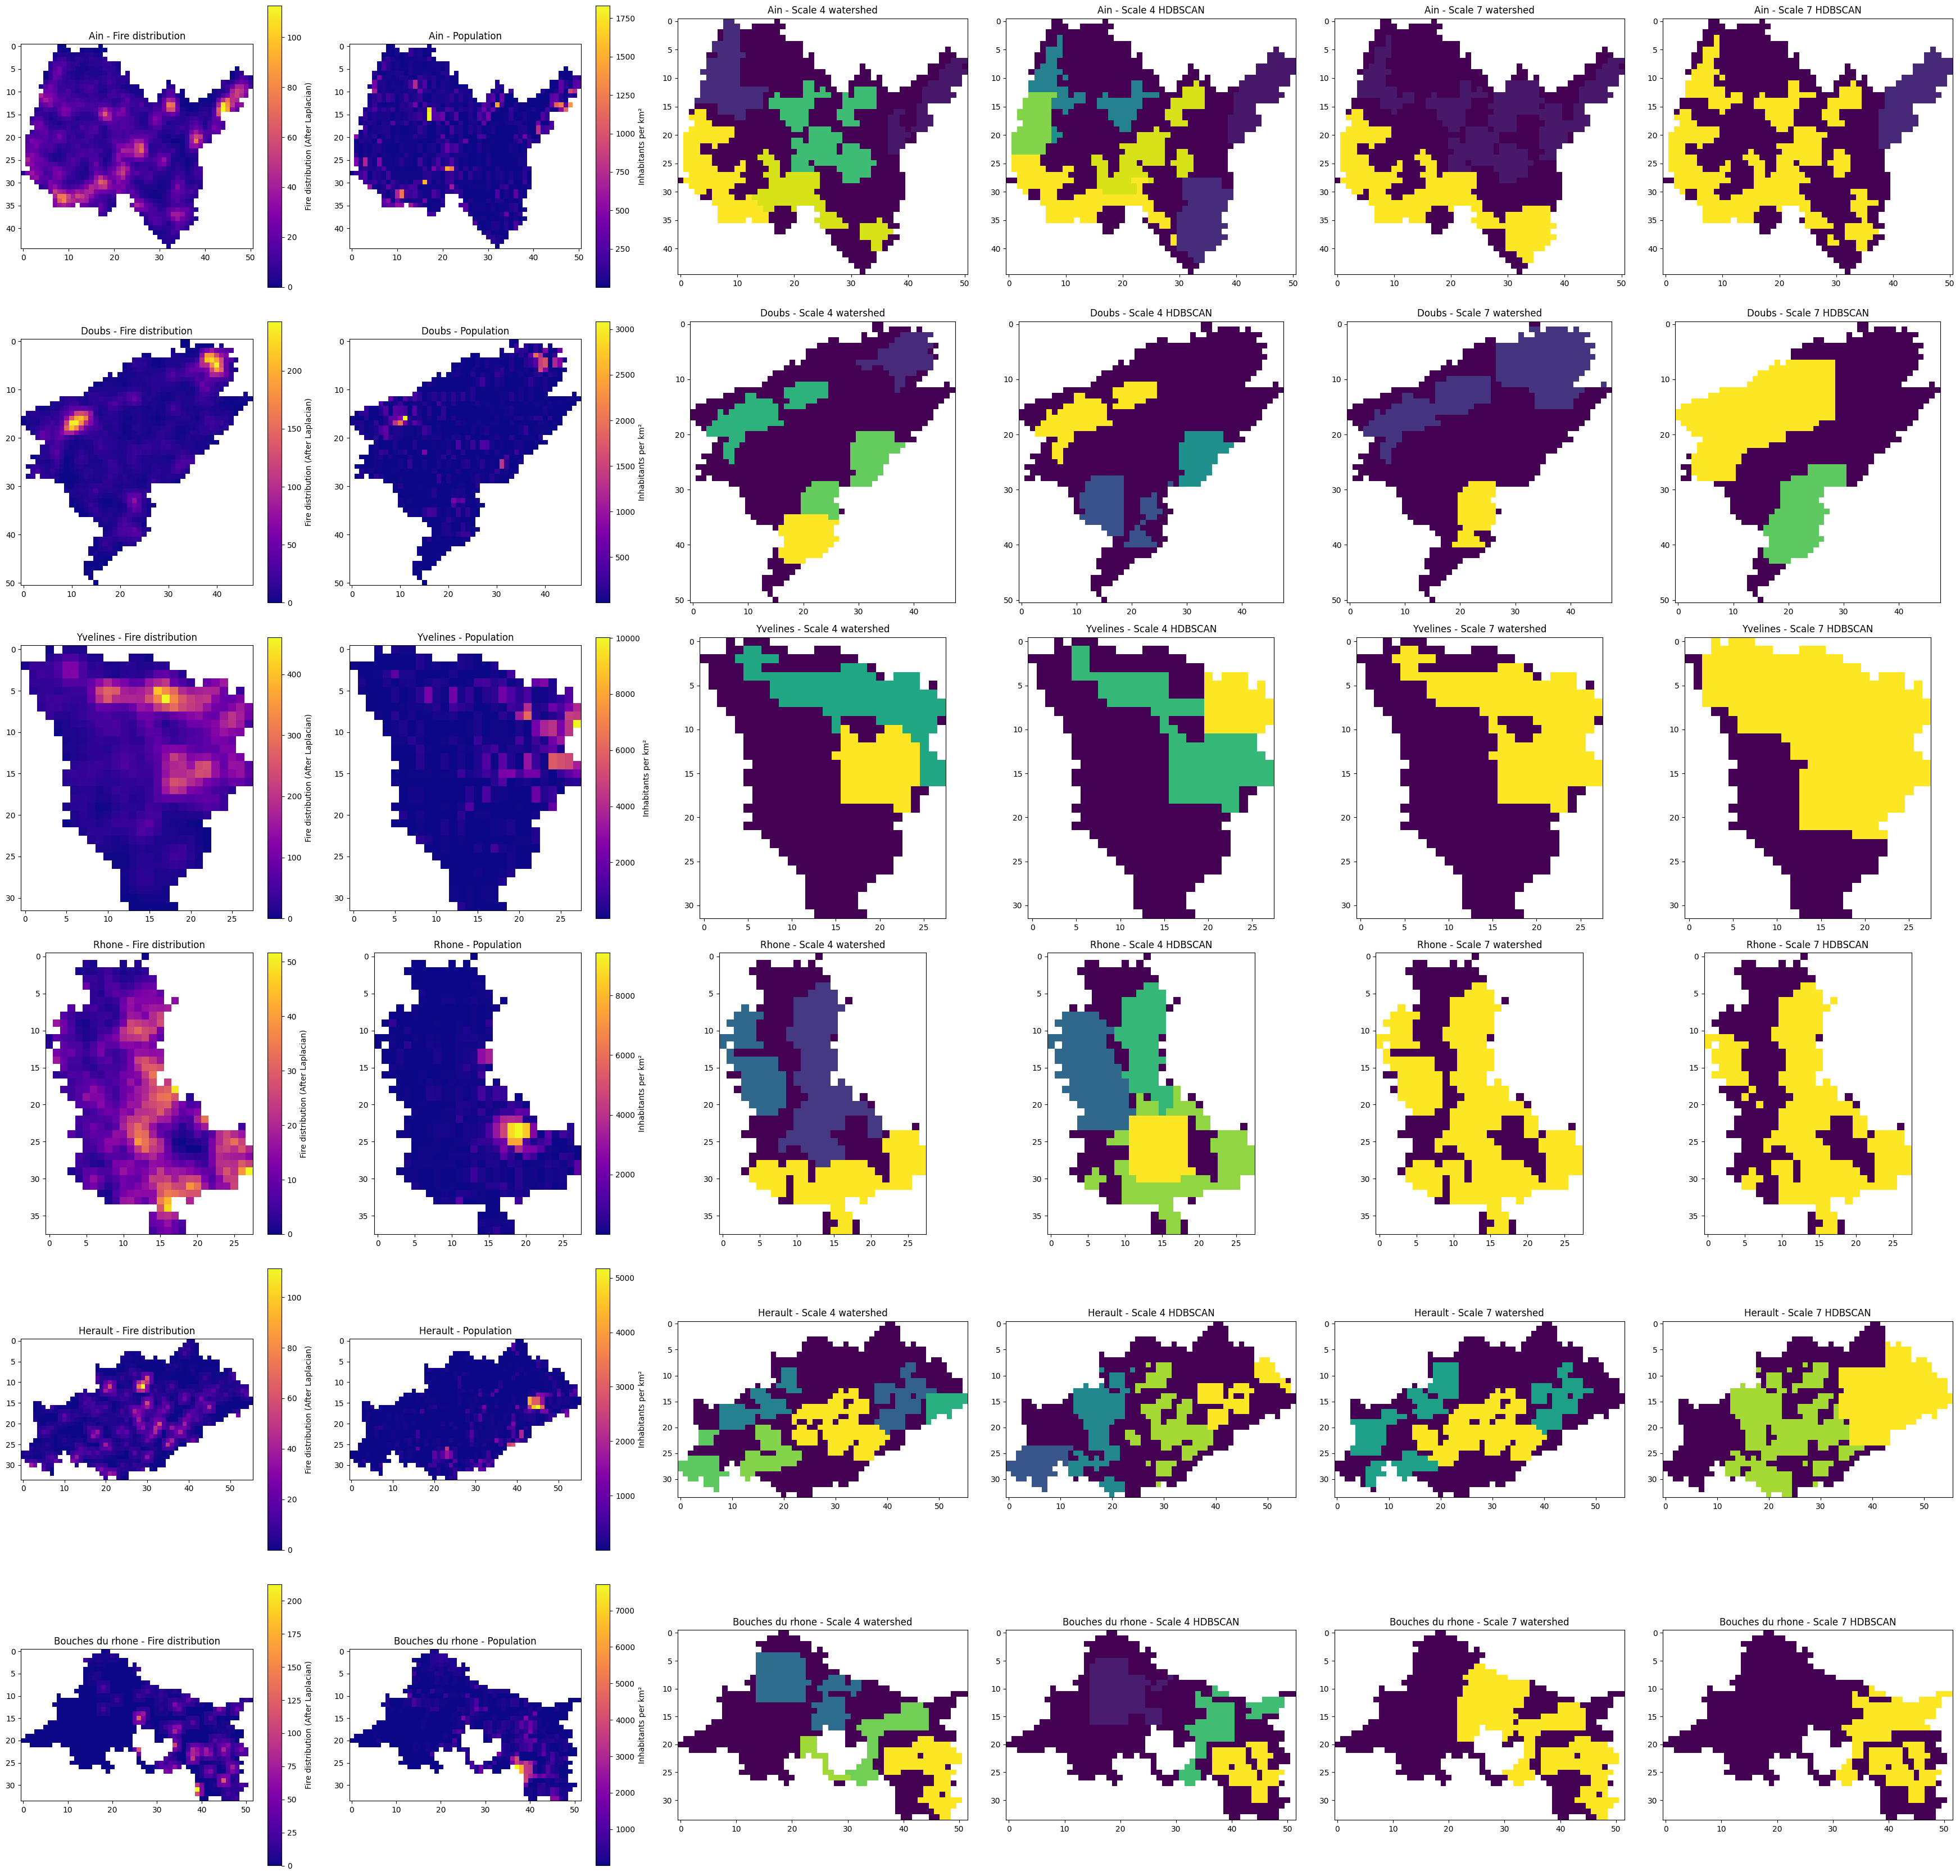

In [25]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_all_departments(data):
    """
    Plot Fire distribution (After Laplacian), Population, Scale4, and Scale7 for all departments in a single figure.

    Parameters:
    - data: Dictionary containing data for all departments.
    """
    departments = list(data.keys())
    num_departments = len(departments)

    # Create a figure with a grid for all departments (num_departments rows, 4 columns)
    fig, axes = plt.subplots(num_departments, 6, figsize=(35, 6 * num_departments))

    for i, department in enumerate(departments):
        # Extract department data
        dept_data = data[department]
        target = dept_data["target"]
        population = dept_data["population"]
        scale4 = dept_data["scale4"]
        scale7 = dept_data["scale7"]
        scale4_clustering = dept_data["scale4_clustering"]
        scale7_clustering = dept_data["scale7_clustering"]

        # Plot Fire distribution (After Laplacian) with colorbar
        im1 = axes[i, 0].imshow(target, cmap="plasma")  # Same cmap as population
        axes[i, 0].set_title(f"{department.capitalize()} - Fire distribution")
        cbar1 = plt.colorbar(im1, ax=axes[i, 0])
        cbar1.set_label('Fire distribution (After Laplacian)')

        # Plot Population with colorbar and units (inhabitants per km²)
        im2 = axes[i, 1].imshow(population, cmap="plasma")
        axes[i, 1].set_title(f"{department.capitalize()} - Population")
        cbar2 = plt.colorbar(im2, ax=axes[i, 1])
        cbar2.set_label('Inhabitants per km²')

        # Plot Scale4
        im3 = axes[i, 2].imshow(scale4)
        axes[i, 2].set_title(f"{department.capitalize()} - Scale 4 watershed")
        #cbar3 = plt.colorbar(im3, ax=axes[i, 2])
        #cbar3.set_label('Sum of fire distribution')

        # Plot Scale4_clustering
        im3 = axes[i, 3].imshow(scale4_clustering)
        axes[i, 3].set_title(f"{department.capitalize()} - Scale 4 HDBSCAN")
        #cbar5 = plt.colorbar(im3, ax=axes[i, 3])
        #cbar5.set_label('Sum of fire distribution')

        # Plot Scale7
        im4 = axes[i, 4].imshow(scale7)
        axes[i, 4].set_title(f"{department.capitalize()} - Scale 7 watershed")
        #cbar4 = plt.colorbar(im4, ax=axes[i, 4])
        #cbar4.set_label('Sum of fire distribution')

        # Plot Scale7_clustering
        im4 = axes[i, 5].imshow(scale7_clustering)
        axes[i, 5].set_title(f"{department.capitalize()} - Scale 7 HDBSCAN")
        #cbar6 = plt.colorbar(im4, ax=axes[i, 5])
        #cbar6.set_label('Sum of fire distribution')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
    
# Exemple d'utilisation
plot_all_departments(data)